In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf


In [2]:
def donchian_breakout(ohlcv, lookback=20):
    
    ohlcv['upper'] = upper = ohlcv['close'].rolling(lookback - 1).max().shift(1)
    ohlcv['lower'] = lower = ohlcv['close'].rolling(lookback - 1).min().shift(1)
    
    signal = pd.Series(np.full(len(ohlcv), np.nan), index=ohlcv.index)
    
    signal.loc[ohlcv['close'] > upper] = 1
    signal.loc[ohlcv['close'] < lower] = -1
    signal = signal.ffill()
    
    return signal

In [3]:
def optimize_donchian(ohlcv):

    best_pf = 0
    best_lookback = -1
    r = np.log(ohlcv['close']).diff().shift(-1)
    for lookback in range(10, 150):
        signal = donchian_breakout(ohlcv, lookback)
        sig_rets = signal * r
        sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()

        if sig_pf > best_pf:
            best_pf = sig_pf
            best_lookback = lookback

    return best_lookback, best_pf

In [4]:
ohlcv = pd.read_csv("data/btc_usdt_2021_2025.csv")
signal = donchian_breakout(ohlcv, lookback=20)
best_lookback, best_pf = optimize_donchian(ohlcv)

print(f"After optimization, the lookback is {best_lookback}, and the best performance is {best_pf:.2f}")

After optimization, the lookback is 91, and the best performance is 1.14


In [22]:
def plot_donchain(ohlcv):
    
    df = ohlcv.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace = True)


    title_font = {'family': 'serif', 'weight': 'bold', 'size': 16}

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['close'], label='closing price', alpha=0.7)
    ax.plot(df.index, df['close'].rolling(best_lookback - 1).max().shift(1), label = 'high band', linestyle = '--')
    ax.plot(df.index, df['close'].rolling(best_lookback - 1).min().shift(1), label = 'low band', linestyle = '-.')

    buy_signals = df[df['close'] > df['upper']]  
    sell_signals = df[df['close'] < df['lower']]

    ax.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal', alpha=1)
    ax.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal', alpha=1)

    ax.legend()
    ax.set_title("Donchain Strategy", fontdict=title_font)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.5)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(12, 6))


    df['return'] = np.log(df['close']).diff().shift(-1) 
    df['donch_return'] = np.array(df.reset_index()['return'] * signal)
    df['cumulative_donch_return'] = df['donch_return'].cumsum()

    ax2.plot(df.index, df['cumulative_donch_return'], label='Cumulative Donchian Return', color='#2962FF')

    # Formatting
    ax2.set_title("Cumulative Returns of Donchian Breakout Strategy")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Cumulative Return")
    ax2.legend()
    ax2.grid(True, alpha=0.5)
    plt.show()


    
    DCU = df[['upper']]
    # DCM = df[['Middle']]
    DCL = df[['lower']]

    apds = [
        mpf.make_addplot(DCU,color='#FF6D00',panel=0,),
        # mpf.make_addplot(DCM,color='#FF6D00',panel=0,),
        mpf.make_addplot(DCL,color='#2962FF',panel=0,),
    ]

    mpf.plot(
        df,
        volume = True, 
        title="Candlestick with Rolling Upper and Lower Bound",
        type='candle',
        fill_between = dict(y1 = df['upper'].values, y2 = df['lower'].values, alpha = 0.1, color = '#2962FF'),  
        style = 'yahoo',
        addplot = apds, 
        figsize=(12, 6),
        warn_too_much_data=5000
        )

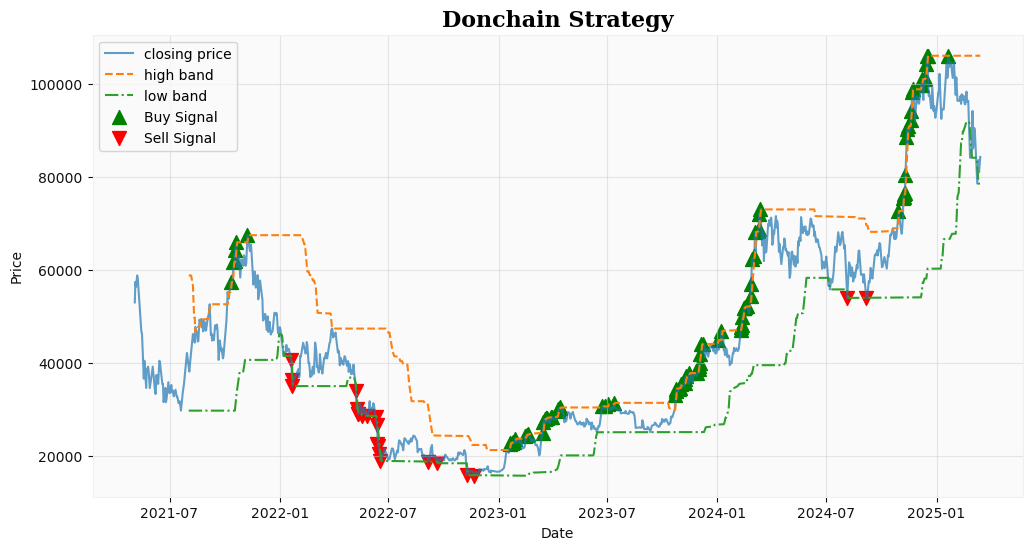

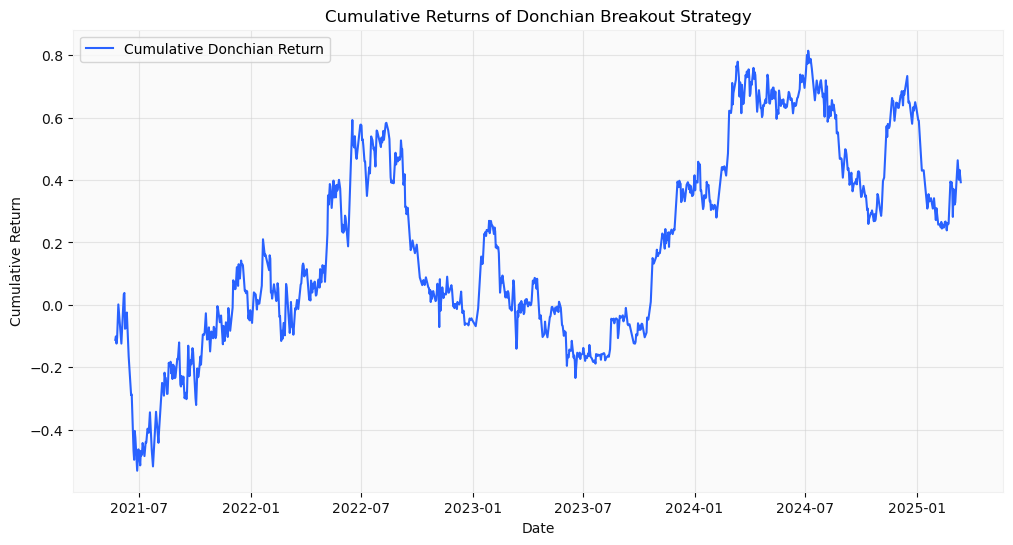

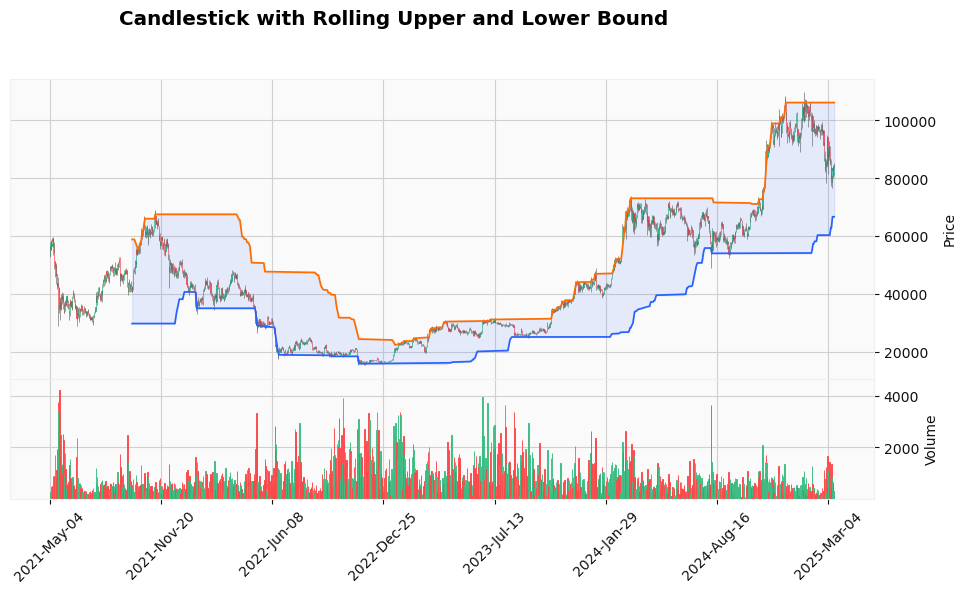

In [23]:
plot_donchain(ohlcv)

In [7]:
def walkforward_donch(ohlc: pd.DataFrame, train_lookback: int = 24 * 365 * 4, train_step: int = 24 * 30):

    n = len(ohlc)
    wf_signal = np.full(n, np.nan)
    tmp_signal = None
    
    next_train = train_lookback
    for i in range(next_train, n):
        if i == next_train:
            best_lookback, _ = optimize_donchian(ohlc.iloc[i-train_lookback:i])
            tmp_signal = donchian_breakout(ohlc, best_lookback)
            next_train += train_step
        
        wf_signal[i] = tmp_signal.iloc[i]
    
    return wf_signal

In [ ]:
def get_permutation(ohlc, start_index = 0, seed=None):
    
    assert start_index >= 0
    np.random.seed(seed)

    if isinstance(ohlc, pd.DataFrame):
        ohlc = [ohlc]
    else:
        time_index = ohlc[0].index
        assert all(np.array_equal(df.index, time_index) for df in ohlc), "Indexes do not match"
    
    n_markets = len(ohlc)
    n_bars = len(ohlc[0])
    perm_index = start_index + 1
    perm_n = n_bars - perm_index

    log_ohlc = [np.log(df[['open', 'high', 'low', 'close']]) for df in ohlc]
    start_bar = np.array([df.iloc[start_index].to_numpy() for df in log_ohlc])

    relative_open = np.array([df['open'].sub(df['close'].shift()).to_numpy()[perm_index:] for df in log_ohlc])
    relative_high = np.array([df['high'].sub(df['open']).to_numpy()[perm_index:] for df in log_ohlc])
    relative_low = np.array([df['low'].sub(df['open']).to_numpy()[perm_index:] for df in log_ohlc])
    relative_close = np.array([df['close'].sub(df['open']).to_numpy()[perm_index:] for df in log_ohlc])

    idx = np.arange(perm_n)
    np.random.shuffle(idx)
    relative_high, relative_low, relative_close = relative_high[:, idx], relative_low[:, idx], relative_close[:, idx]
    np.random.shuffle(idx)
    relative_open = relative_open[:, idx]

    perm_ohlc = []
    for i, df in enumerate(log_ohlc):
        perm_bars = np.zeros((n_bars, 4))
        perm_bars[:start_index] = df.to_numpy()[:start_index]
        perm_bars[start_index] = start_bar[i]

        for j, k in enumerate(range(perm_index, n_bars)):
            perm_bars[k, 0] = perm_bars[k - 1, 3] + relative_open[i, j]
            perm_bars[k, 1] = perm_bars[k, 0] + relative_high[i, j]
            perm_bars[k, 2] = perm_bars[k, 0] + relative_low[i, j]
            perm_bars[k, 3] = perm_bars[k, 0] + relative_close[i, j]

        perm_df = pd.DataFrame(np.exp(perm_bars), index=df.index, columns=['open', 'high', 'low', 'close'])
        perm_ohlc.append(perm_df)
    
    return perm_ohlc if n_markets > 1 else perm_ohlc[0]